In [55]:
from geopy.distance import geodesic
import partridge as pt
import pandas as pd
from meteostat import Point as MeteoPoint, Hourly as MeteoHourly
from datetime import datetime
import data_processing as dp
import geopandas as gpd
from shapely.geometry import Point as GeoPoint


In [56]:
feed = pt.load_feed("gtfs")

# Inspect key tables
stops = feed.stops
stop_times = feed.stop_times
routes = feed.routes
trips = feed.trips


In [57]:
feed.feed_info

,feed_publisher_name,feed_publisher_url,feed_lang,feed_start_date,feed_end_date,feed_version,feed_contact_email
0,MBTA,http://www.mbta.com,EN,2023-01-25,2023-03-11,"Winter 2023, 2023-02-01T21:58:20+00:00, version D",developer@mbta.com


In [58]:
print("Stops Table:\n", stops.head())


Stops Table:
   stop_id stop_code                      stop_name stop_desc platform_code  \
0       1         1   Washington St opp Ruggles St       NaN           NaN   
1      10        10  Theo Glynn Way @ Newmarket Sq       NaN           NaN   
2   10000     10000       Tremont St opp Temple Pl       NaN           NaN   
3   10003     10003       Albany St opp Randall St       NaN           NaN   
4   10005     10005     Albany St opp E Concord St       NaN           NaN   

  platform_name   stop_lat   stop_lon              zone_id stop_address  \
0           NaN  42.330957 -71.082754  ExpressBus-Downtown          NaN   
1           NaN  42.330555 -71.068787             LocalBus          NaN   
2           NaN  42.355692 -71.062911             LocalBus          NaN   
3           NaN  42.331591 -71.076237             LocalBus          NaN   
4           NaN  42.335017 -71.071280             LocalBus          NaN   

                           stop_url level_id  location_type parent

In [59]:
bike_data = pd.read_csv('data/boston/202301-bluebikes-tripdata.csv')
boston = MeteoPoint(42.3601, -71.0589)  # Latitude and Longitude for Boston
start = datetime(2023, 1, 1)
end = datetime(2023, 1, 31)

weather_data_hourly = MeteoHourly(boston, start, end)
weather_data_hourly = weather_data_hourly.fetch()


In [60]:
weather_data_hourly = weather_data_hourly.reset_index()
bike_data['starttime'] = pd.to_datetime(bike_data['starttime'])
weather_data_hourly['time'] = pd.to_datetime(weather_data_hourly['time'])

bike_weather_data = pd.merge_asof(bike_data, weather_data_hourly, left_on='starttime', right_on='time', direction='nearest')


In [61]:
bike_weather_data = bike_weather_data.drop(columns=['snow', 'wpgt', 'tsun'])
bike_weather_data = dp.distance_feature(bike_weather_data)
bike_weather_data = dp.speed_feature(bike_weather_data)
bike_weather_data = dp.date_related_features(bike_weather_data)

## Mass Transit data features

### Frequencies feature

In [62]:
# Create geometry columns for start and end stations
bike_weather_data['start_geometry'] = bike_weather_data.apply(
    lambda x: GeoPoint(x['start station longitude'], x['start station latitude']), axis=1
)
bike_weather_data['end_geometry'] = bike_weather_data.apply(
    lambda x: GeoPoint(x['end station longitude'], x['end station latitude']), axis=1
)


In [63]:
# Convert bike_weather_data to a GeoDataFrame using start_geometry as the default geometry
bike_gdf = gpd.GeoDataFrame(bike_weather_data, geometry='start_geometry')


In [64]:
# Convert stops DataFrame to a GeoDataFrame
stops['geometry'] = stops.apply(lambda x: GeoPoint(x['stop_lon'], x['stop_lat']), axis=1)
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry')


In [65]:
# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
bike_gdf.set_crs(epsg=4326, inplace=True)
stops_gdf.set_crs(epsg=4326, inplace=True)

# Convert CRS to a projection that allows distance calculations in meters (EPSG:3857)
stops_gdf = stops_gdf.to_crs(epsg=3857)
bike_gdf = bike_gdf.to_crs(epsg=3857)


In [66]:
radius = 500  # Example radius in meters
bike_gdf['buffer'] = bike_gdf.geometry.buffer(radius)
# Spatial joins to count nearby stops
start_nearby_counts = gpd.sjoin(stops_gdf, bike_gdf.set_geometry('buffer'), how='inner', predicate='within')

# Set end_geometry as the active geometry
bike_gdf.set_geometry('end_geometry', inplace=True) 
bike_gdf = bike_gdf.set_crs(epsg=4326, inplace=True).to_crs(epsg=3857)

bike_gdf['buffer'] = bike_gdf.geometry.buffer(radius)
end_nearby_counts = gpd.sjoin(stops_gdf, bike_gdf.set_geometry('buffer'), how='inner', predicate='within')


In [67]:
# Count the number of nearby stops for each unique start and end station
start_station_nearby_counts = start_nearby_counts.groupby('index_right').size()
end_station_nearby_counts = end_nearby_counts.groupby('index_right').size()

# Add the counts back to the original bike_weather_data
bike_weather_data['start_station_nearby_stations'] = bike_weather_data.index.map(start_station_nearby_counts).fillna(0).astype(int)
bike_weather_data['end_station_nearby_stations'] = bike_weather_data.index.map(end_station_nearby_counts).fillna(0).astype(int)



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



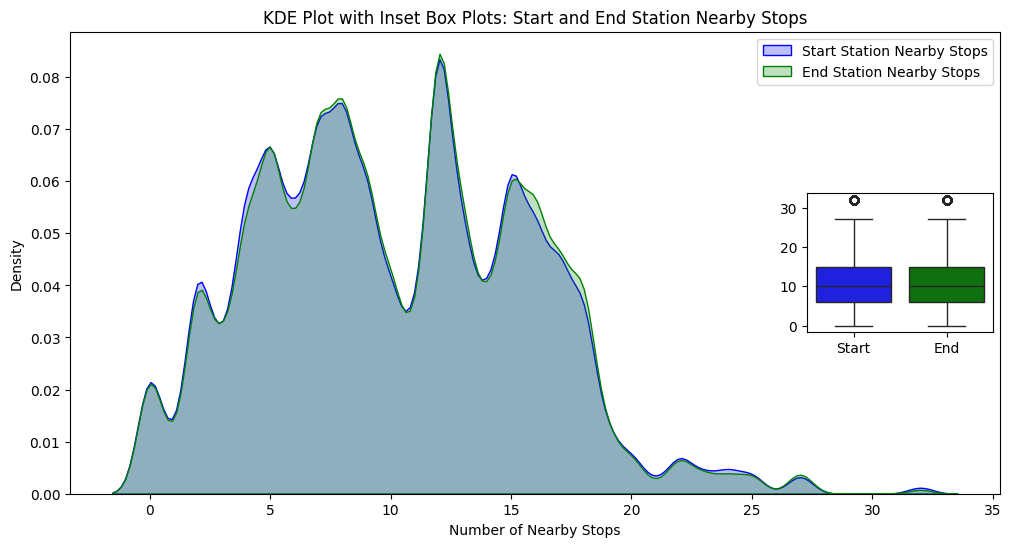

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set up the main figure and axes
fig, main_ax = plt.subplots(figsize=(12, 6))

# KDE plots on the main axis
sns.kdeplot(bike_weather_data['start_station_nearby_stations'], ax=main_ax, color='blue', shade=True, label='Start Station Nearby Stops')
sns.kdeplot(bike_weather_data['end_station_nearby_stations'], ax=main_ax, color='green', shade=True, label='End Station Nearby Stops')

main_ax.set_title('KDE Plot with Inset Box Plots: Start and End Station Nearby Stops')
main_ax.set_xlabel('Number of Nearby Stops')
main_ax.set_ylabel('Density')
main_ax.legend()

# Create inset axes for the box plot
inset_ax = inset_axes(main_ax, width="20%", height="30%", loc='right')  # Adjust size and position as needed

# Box plots on the inset axis
sns.boxplot(data=[
    bike_weather_data['start_station_nearby_stations'], 
    bike_weather_data['end_station_nearby_stations']
], ax=inset_ax, palette=['blue', 'green'])

# Remove x-axis labels from the inset box plot for a cleaner look
inset_ax.set_xticklabels(['Start', 'End'])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

plt.show()


In [70]:
print(bike_weather_data[['start_station_nearby_stations', 'end_station_nearby_stations']].head())


   start_station_nearby_stations  end_station_nearby_stations
0                             16                            8
1                             10                           16
2                             10                           16
3                              1                           12
4                             12                           20


In [88]:
q1 = bike_weather_data['start_station_nearby_stations'].quantile(0.25)
q2 = bike_weather_data['start_station_nearby_stations'].quantile(0.75)
print(q1, q2)

6.0 15.0


In [89]:
# Define thresholds for categorization based on the quantiles and encode directly
def encode_nearby_stops(count):
    if count <= 5:
        return 0  # 0 = Badly Connected
    elif 6 <= count <= 15:
        return 1  # 1 = Moderately Connected
    else:
        return 2  # 2 = Well Connected

# Apply encoding to both features
bike_weather_data['start_station_connection_encoded'] = bike_weather_data['start_station_nearby_stations'].apply(encode_nearby_stops)
bike_weather_data['end_station_connection_encoded'] = bike_weather_data['end_station_nearby_stations'].apply(encode_nearby_stops)


In [90]:
bike_weather_data

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,start_month,end_hour,end_dayofweek,end_month,start_geometry,end_geometry,start_station_nearby_stations,end_station_nearby_stations,start_station_connection_encoded,end_station_connection_encoded
0,250,2023-01-01 00:02:54.080,2023-01-01 00:07:04.4100,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,21,Prudential Center - 101 Huntington Ave,42.346520,...,1,0,6,1,POINT (-71.07739206866427 42.34992828230057),POINT (-71.08065776545118 42.34652003998412),16,8,2,1
1,489,2023-01-01 00:10:33.310,2023-01-01 00:18:42.3690,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,...,1,0,6,1,POINT (-71.0794677917329 42.349589423682445),POINT (-71.08336953450817 42.34135615767354),10,16,1,2
2,461,2023-01-01 00:10:49.913,2023-01-01 00:18:31.1280,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,...,1,0,6,1,POINT (-71.0794677917329 42.349589423682445),POINT (-71.08336953450817 42.34135615767354),10,16,1,2
3,1065,2023-01-01 00:13:58.064,2023-01-01 00:31:43.5090,58,Mugar Way at Beacon St,42.355536,-71.072869,345,Park Plaza at Charles St S.,42.351828,...,1,0,6,1,POINT (-71.07286870479584 42.35553628489709),POINT (-71.06781138111728 42.35182806892068),1,12,0,1
4,601,2023-01-01 00:14:02.613,2023-01-01 00:24:03.8950,50,Boylston St at Berkeley St,42.351142,-71.073292,374,Tremont St at Hamilton Pl,42.356683,...,1,0,6,1,POINT (-71.07329249382019 42.3511419825475),POINT (-71.06166645884514 42.35668334969929),12,20,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140335,1512,2023-01-31 23:48:32.137,2023-02-01 00:13:44.2450,33,Kenmore Square,42.348706,-71.097009,330,30 Dane St,42.381001,...,1,0,2,2,POINT (-71.097009 42.348706),POINT (-71.10402522613185 42.38100143038052),16,15,2,1
140336,350,2023-01-31 23:50:02.279,2023-01-31 23:55:52.4900,566,Main Street/Albany Street/Technology Square,42.362902,-71.091567,386,Sennott Park Broadway at Norfolk Street,42.368605,...,1,23,1,1,POINT (-71.0915669 42.3629016),POINT (-71.09930185605663 42.36860524248197),7,17,1,2
140337,2174,2023-01-31 23:50:15.069,2023-02-01 00:26:29.5040,583,Broad Canal Way at Third Street,42.363045,-71.082871,452,1200 Beacon St,42.344149,...,1,0,2,2,POINT (-71.08287078916874 42.36304549626695),POINT (-71.11467361450195 42.34414898749529),3,6,0,1
140338,149,2023-01-31 23:51:36.447,2023-01-31 23:54:05.5680,183,Alewife MBTA at Steel Place,42.395588,-71.142606,319,84 Cambridgepark Dr,42.393600,...,1,23,1,1,POINT (-71.14260613918304 42.39558845716709),POINT (-71.143941 42.3936),2,2,0,0


In [ ]:
bik

## Transit Frequency

In [ ]:
def time_to_seconds(time_str):
    """Convert time in HH:MM:SS format to seconds since midnight."""
    time_obj = pd.to_datetime(time_str).time()
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

def calculate_service_frequency(nearby_stops_dict, bike_station_latitude, bike_station_longitude, stop_times, trip_time_seconds, time_window=1800):
    # Retrieve precomputed nearby stops for the station
    nearby_stop_ids = nearby_stops_dict.get((bike_station_latitude, bike_station_longitude), [])
    
    # Filter `stop_times` for relevant stop IDs and within the time window
    relevant_stop_times = stop_times[
        (stop_times['stop_id'].isin(nearby_stop_ids)) &
        (abs(stop_times['arrival_time'] - trip_time_seconds) <= time_window)
    ]
    
    # Return the count of relevant stop times
    return relevant_stop_times.shape[0]

In [ ]:
# Create a dictionary to store nearby stops for each unique bike station
nearby_stops_dict = {}

for _, station in bike_weather_data[['start station latitude', 'start station longitude']].drop_duplicates().iterrows():
    station_coords = (station['start station latitude'], station['start station longitude'])
    # Find nearby stops within the specified radius and store them
    nearby_stops_dict[(station['start station latitude'], station['start station longitude'])] = stops[
        stops.apply(lambda x: geodesic(station_coords, (x['stop_lat'], x['stop_lon'])).meters <= 500, axis=1)
    ]['stop_id'].tolist()


In [ ]:
# Convert starttime and stoptime to seconds since midnight
bike_weather_data['start_trip_time'] = bike_weather_data['starttime'].apply(time_to_seconds)
bike_weather_data['end_trip_time'] = bike_weather_data['stoptime'].apply(time_to_seconds)


In [ ]:
# Applying the function to calculate frequency based on the new time format
bike_weather_data['start_station_frequency'] = bike_weather_data.apply(
    lambda x: calculate_service_frequency(
        nearby_stops_dict, x['start station latitude'], x['start station longitude'], stop_times, x['start_trip_time']
    ), axis=1
)
bike_weather_data['end_station_frequency'] = bike_weather_data.apply(
    lambda x: calculate_service_frequency(
        nearby_stops_dict, x['end station latitude'], x['end station longitude'], stop_times, x['end_trip_time']
    ), axis=1
)